In [210]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    
    library(gtools, quietly = T)
    library(HGNChelper, quietly = T)
    
    library(dplyr, quietly = T)
    library(openxlsx, quietly = T)
    library(reshape2, quietly = T)
    library(data.table, quietly = T) 
    
    library(ggplot2, quietly = T)
    library(ggpubr, quietly = T)
    library(RColorBrewer, quietly = T)

})

sctype_path = '/data2/hratch/Software/'
data_path = '/data3/hratch/norcross_abc/'

In [211]:
abc.integrated<-readRDS(paste0(data_path, 'interim/abc_sctype_annotated.RDS'))

We have 3 criteria for looking more closely at cluster annotations:
1) low confidence annotation by ScType ("low" confidence if the ScType score is < 0 or < 0.25*# of cells in that cluster): clusters 12 and 13
2) many-to-one mappings of clusters to cell types in which those clusters are not in proximity in UMAP space: clusters pDCs (clusters 11 and 22), NK cells (clusters 13 and 19)
3) if the markers indicate multiple populations or a different population from the ScType annotation

Criteria #1-2 will include re-examining the the QC metrics. Additionally, we will double check the QC of cluster 5 (annotated as basophils). This clusters lie near 12/13, and it is unclear from the markers what their correct annotation is. Since cluster 8 is near these 3 clusters, we'll also double check that.

In [212]:
low.clusters<-c(5,8,12,13)
seurat.clusters<-abc.integrated$seurat_clusters
other.clusters<-setdiff(seurat.clusters, low.clusters)

In [213]:
abc.viz<-abc.integrated
abc.viz$seurat_clusters<-factor(x = seurat.clusters,levels = c(low.clusters, other.clusters))

In [214]:
md<-abc.viz@meta.data

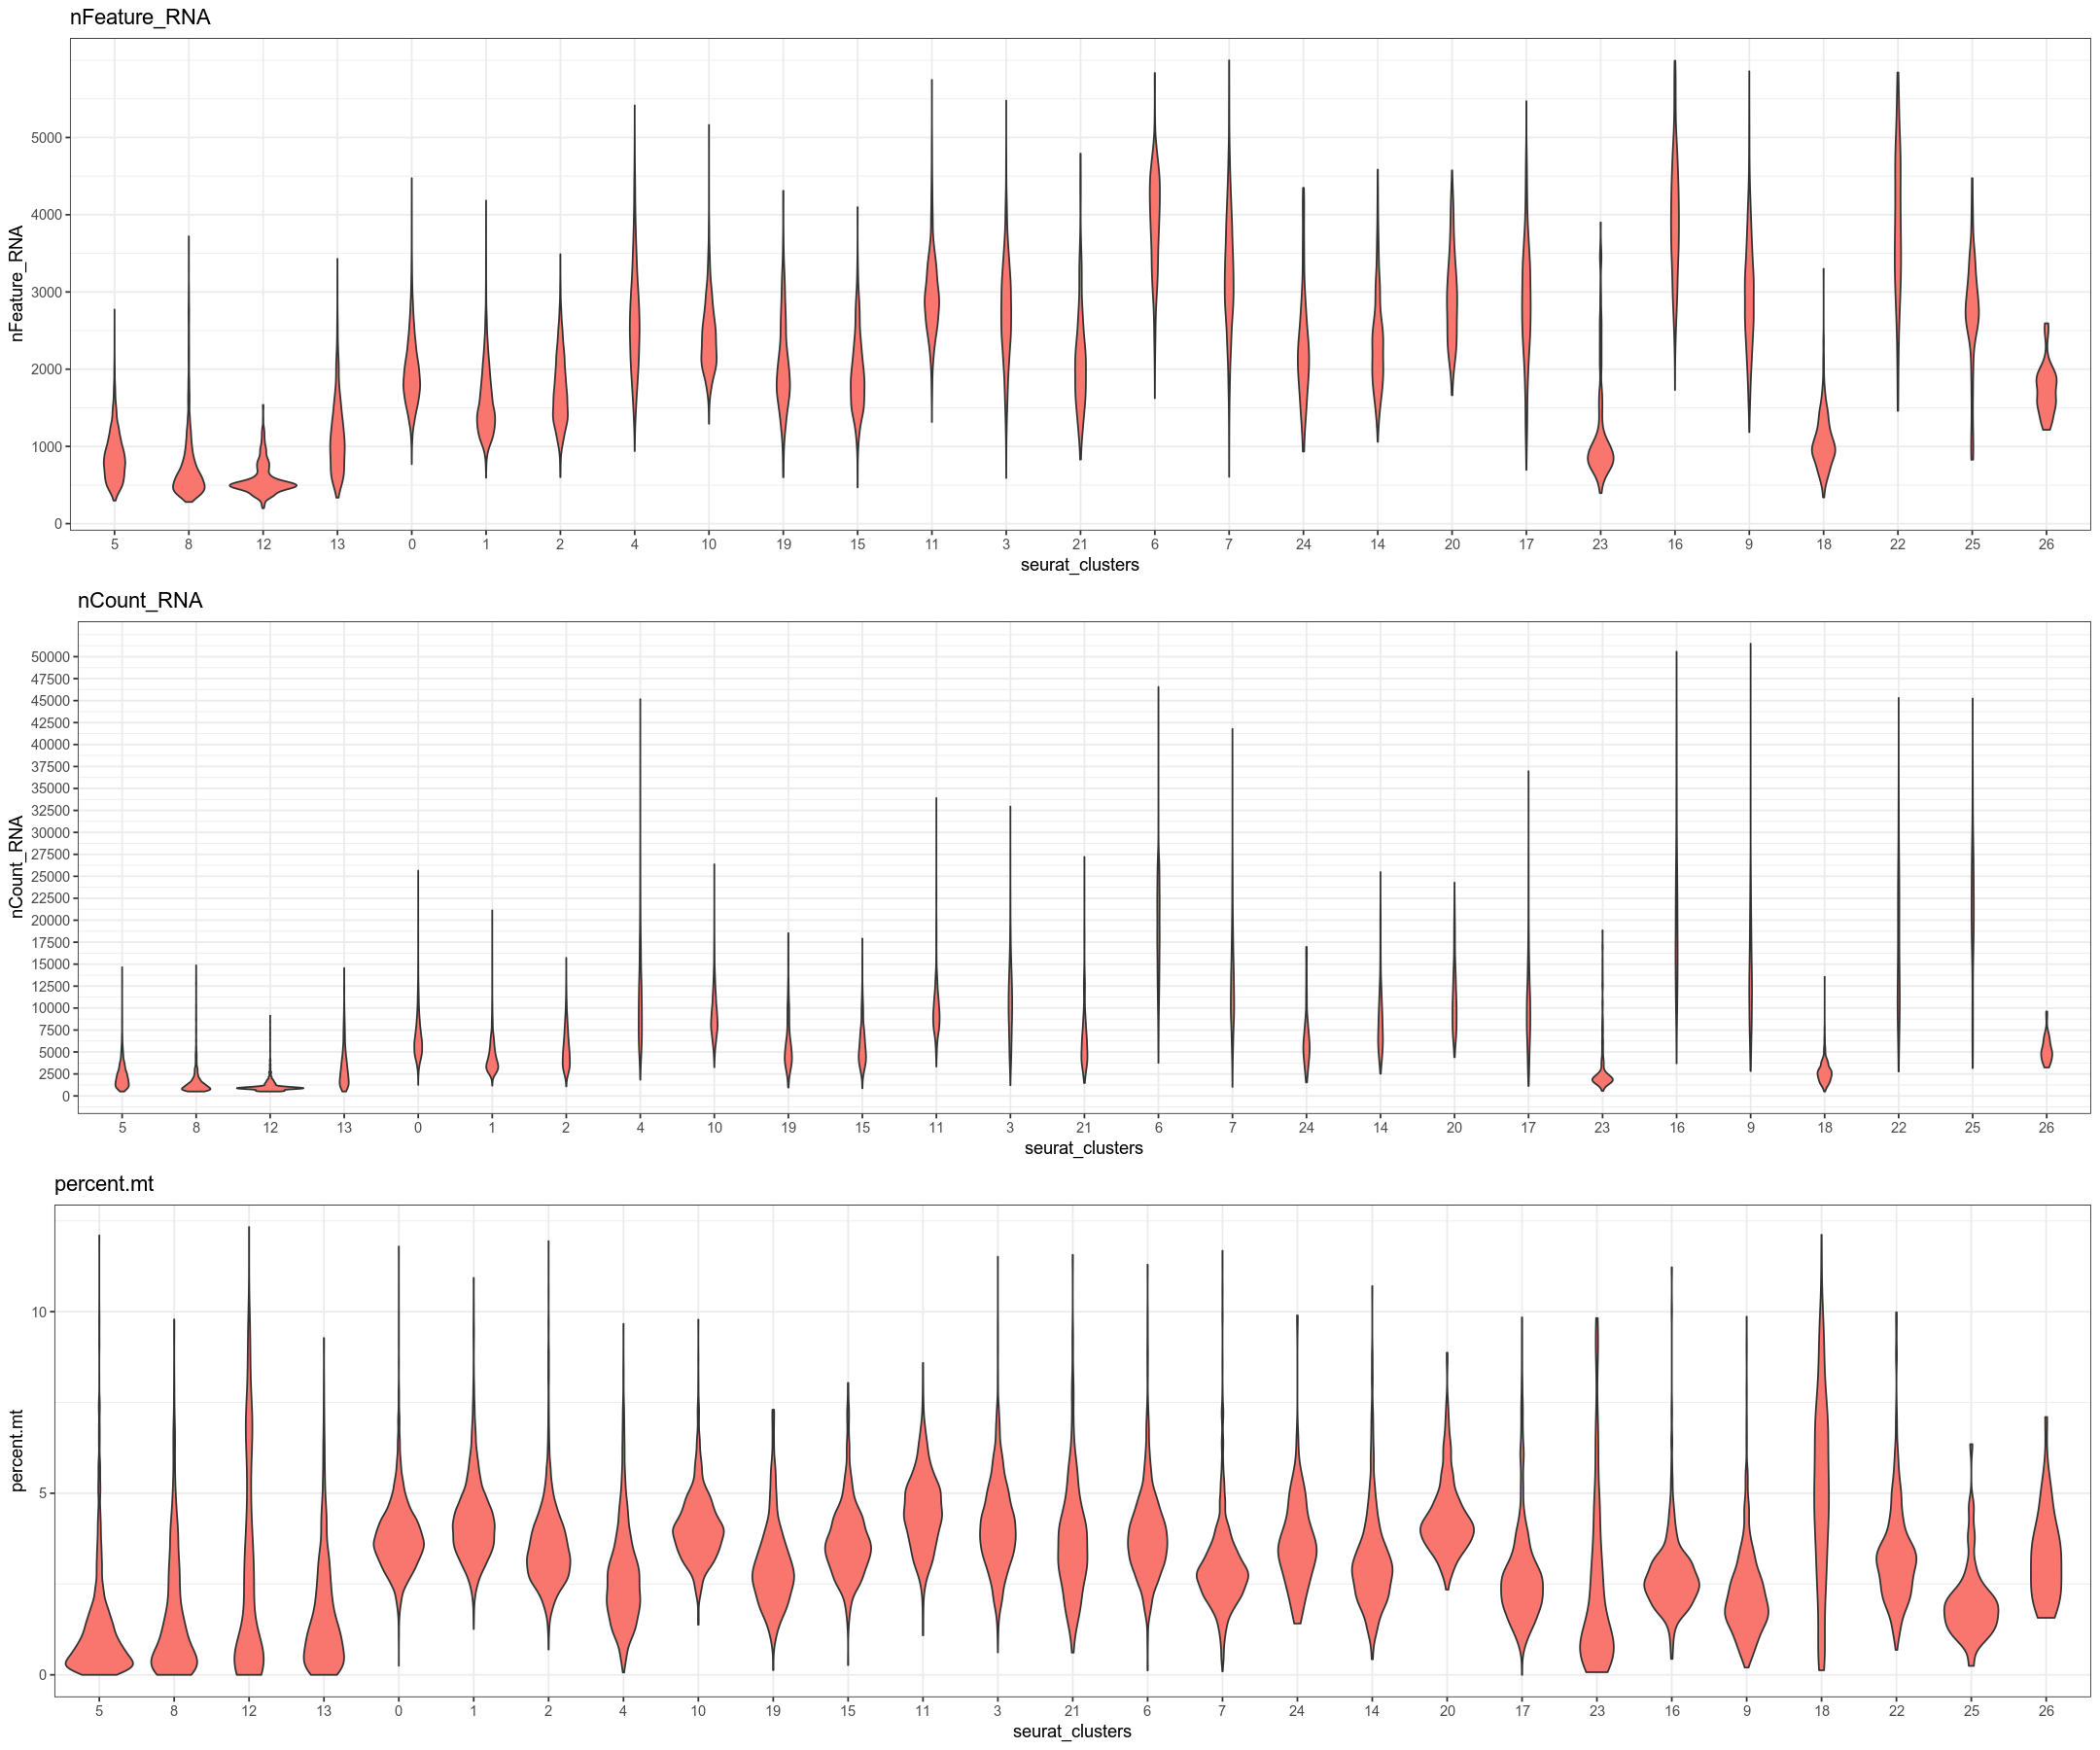

In [215]:
h_ = 15
w_ = 18
options(repr.plot.height=h_, repr.plot.width=w_)

gAi<-ggplot(data = md, aes(x = seurat_clusters, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none") + ggtitle('nFeature_RNA')

gAii<-ggplot(data = md, aes(x = seurat_clusters, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
theme_bw()+theme(legend.position="none")+ ggtitle('nCount_RNA')

gAiii<-ggplot(data = md, aes(x = seurat_clusters, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
theme_bw()+theme(legend.position="none")+ ggtitle('percent.mt')


g1<-ggarrange(gAi, gAii, gAiii, ncol = 1)


g1

# QC checks

In [3]:
clusters<-c(5, 8, 11, 12, 13, 19, 22)
abc.viz<-subset(abc.integrated, seurat_clusters %in% clusters)
md<-abc.viz@meta.data

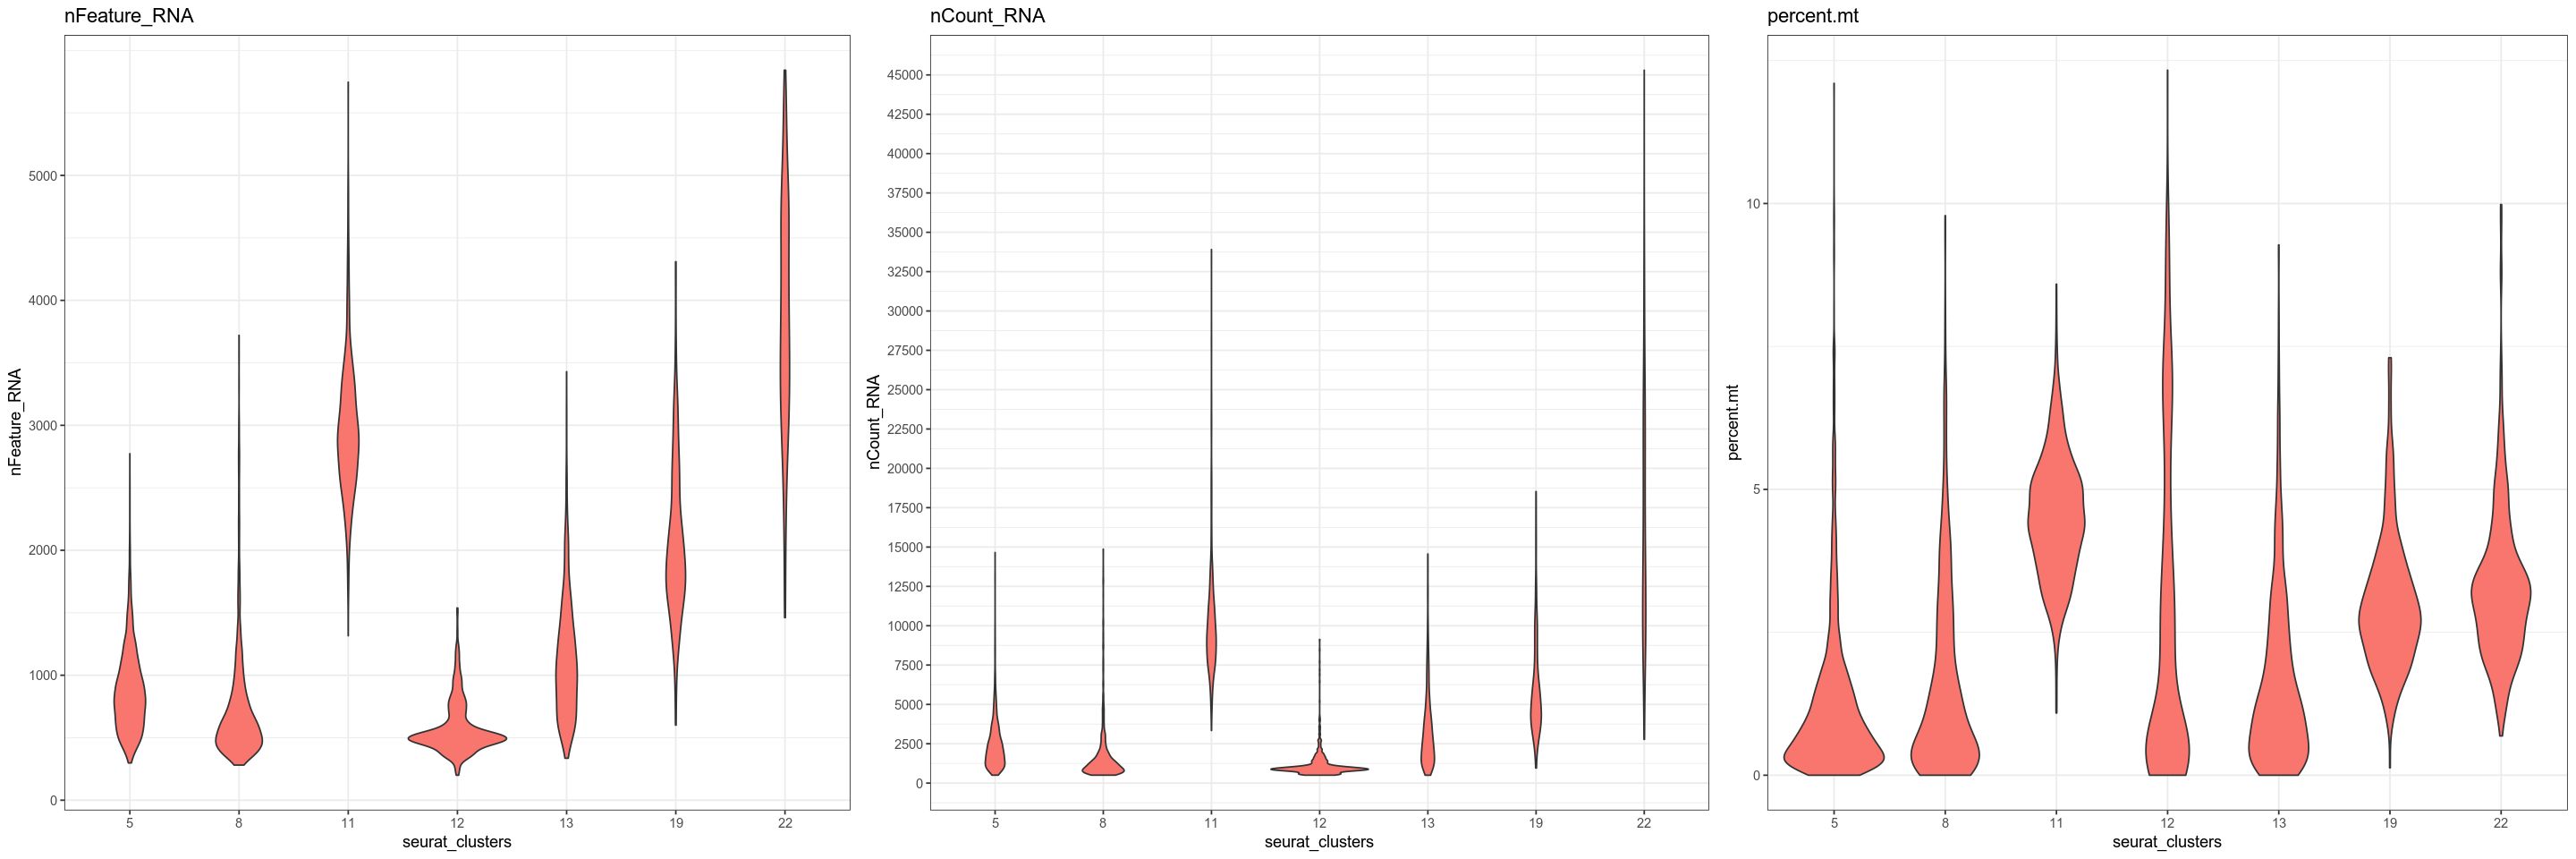

In [4]:
h_ = 8
w_ = 24
options(repr.plot.height=h_, repr.plot.width=w_)

gAi<-ggplot(data = md, aes(x = seurat_clusters, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none") + ggtitle('nFeature_RNA')

gAii<-ggplot(data = md, aes(x = seurat_clusters, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
theme_bw()+theme(legend.position="none")+ ggtitle('nCount_RNA')

gAiii<-ggplot(data = md, aes(x = seurat_clusters, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
theme_bw()+theme(legend.position="none")+ ggtitle('percent.mt')


g1<-ggarrange(gAi, gAii, gAiii, ncol = 3)

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/','reannotation_QC', ext), g1, 
                                             height = h_, width = w_)} 

g1

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


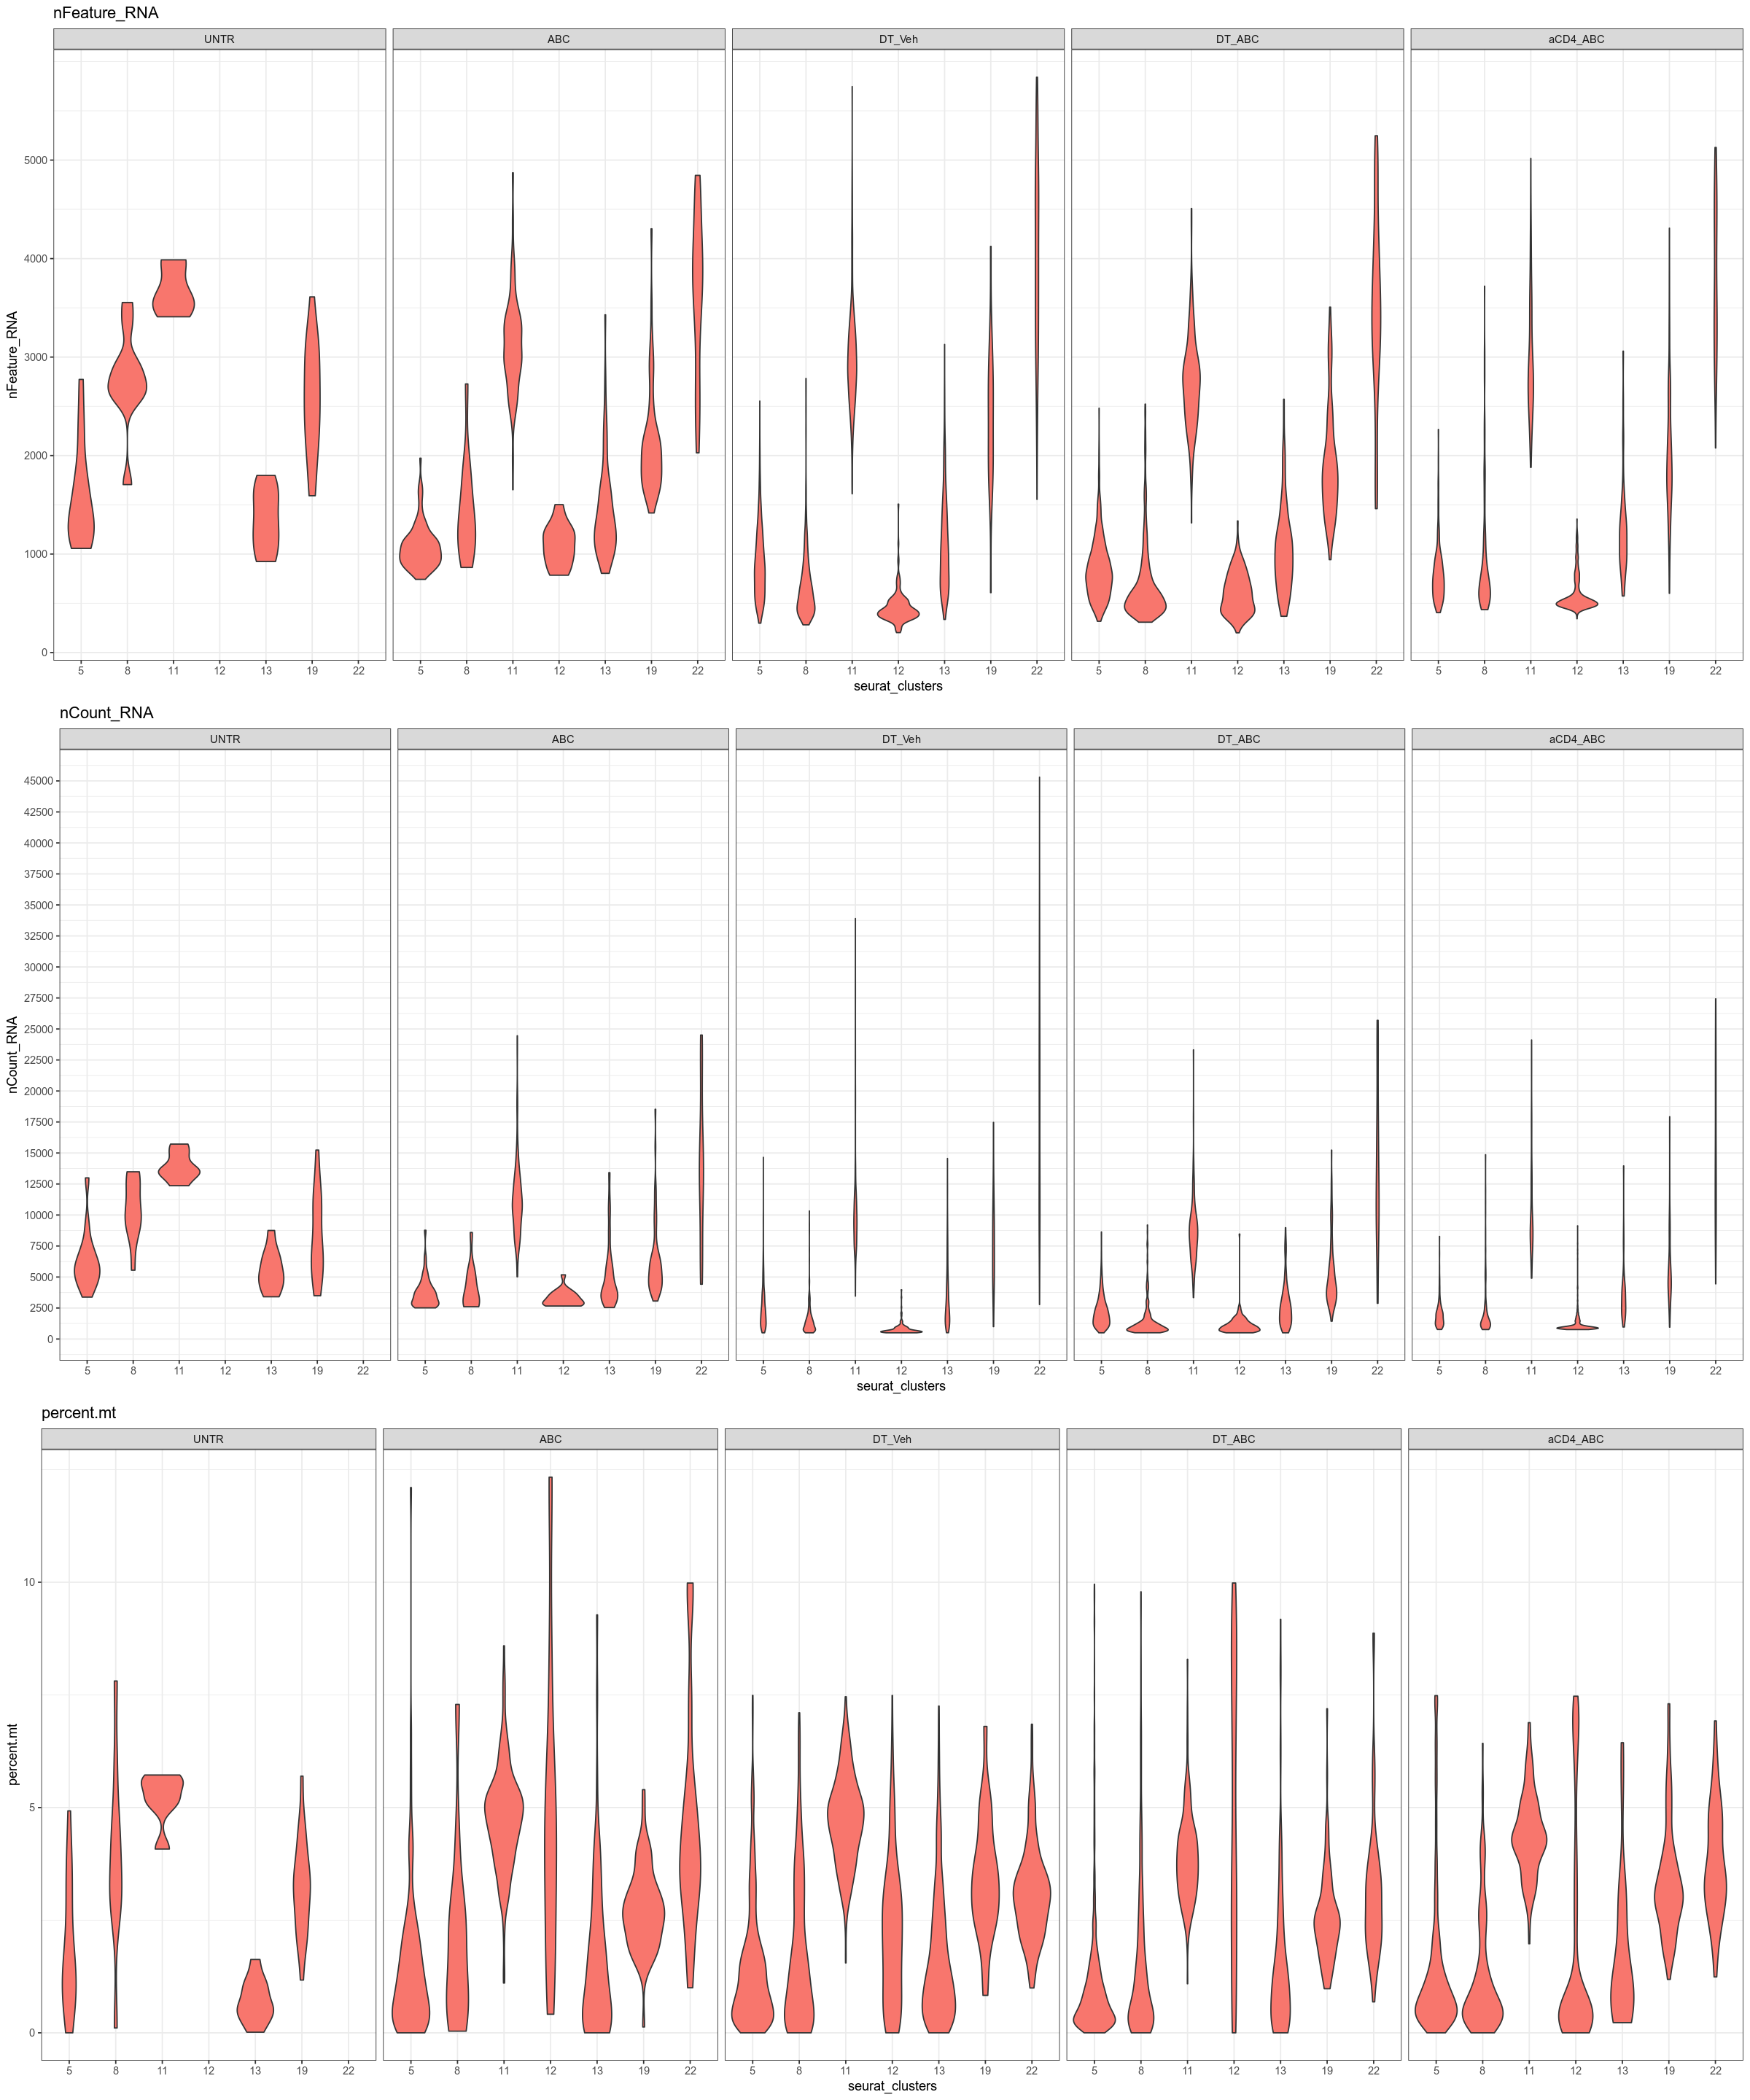

In [5]:
h_ = 24
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

gAi<-ggplot(data = md, aes(x = seurat_clusters, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
facet_wrap(~orig.ident, ncol = 5)+
theme_bw()+theme(legend.position="none") + ggtitle('nFeature_RNA')

gAii<-ggplot(data = md, aes(x = seurat_clusters, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
facet_wrap(~orig.ident, ncol = 5)+
theme_bw()+theme(legend.position="none")+ ggtitle('nCount_RNA')

gAiii<-ggplot(data = md, aes(x = seurat_clusters, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
facet_wrap(~orig.ident, ncol = 5)+
theme_bw()+theme(legend.position="none")+ ggtitle('percent.mt')


g2<-ggarrange(gAi, gAii, gAiii, ncol = 1, nrow = 3)

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/','reannotation_bysample_QC', ext),
                                              g2, 
                                             height = h_, width = w_)} 

g2

It seems that clusters 5, 8, 12 and 13, which lie near each other in UMAP space, may represent more low quality cells.  12 and 13  both fall under criteria #1. This would also resolve issues with NK cells in criteria #2. This was something that was difficult to catch in the pre-processing. We drop these clusters from the data.

In [6]:
clusters.drop<-c(5, 8, 12, 13)
clusters.keep<-as.integer(setdiff(unique(abc.integrated$seurat_clusters), clusters.drop))

abc.integrated<-subset(abc.integrated, seurat_clusters %in% clusters.keep)

Additionally, we will re-name myeloid DCs (clusters 4, 9, 14, and 18) as cDCs. Biologically, from the Wilcoxon markers, these are the same

# Re-annotation

Based on Wilcoxon marker results from script 01Bi, we rename: myeloid DC as cDC,  Cluster 16 progenitor cells as Xcr1+ DC, and Cluster 21 Effector CD4+ T cells as Tregs

In [7]:
clusters<-as.character(abc.integrated$seurat_clusters)

cell.types<-as.character(abc.integrated$Cell.Type.ScType)
cell.types[cell.types == 'Myeloid Dendritic cells'] = 'Conventional Dendritic cells'
# cell.types[(cell.types == 'Progenitor cells') & (clusters == '16')] = 'Xcr1+ Dendritic cells'
# cell.types[(cell.types == 'Effector CD4+ T cells') & (clusters == '21')] = 'CD4+ Regulatory T cells'
cell.types[(clusters == '16')] = 'Xcr1+ Dendritic cells'
cell.types[(clusters == '21')] = 'CD4+ Regulatory T cells'

# Subclustering

We will subcluster some clusters due to uncertainties from the Wilcoxon marker results

In [54]:
pca.var<-function(so, n_pcs_test = 100, pc.thresh = 0.15){
    total_variance <- sum(matrixStats::rowVars(so@assays$integrated@scale.data))
    eigValues = (so@reductions$pca@stdev)^2
    varExplained = eigValues / total_variance


    viz_df = data.frame(varExplained)
    viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
    viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

    n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
    print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) # 48!
    g<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point()
    if (n_pcs <= n_pcs_test){g<-g+geom_vline(xintercept = n_pcs, color = 'blue')}
    
    return(list(n.pcs = min(30, n_pcs), pc.var.graph = g))
}

subcluster<-function(so, cluster_label, resolution = 0.5, n_pcs_test = 100){
    suppressWarnings({
        suppressMessages({
#             so.subset<-subset(so, seurat_clusters %in% cluster_label)
            so.subset<-subset(so, seurat_clusters == cluster_label)
            so.subset<-RunPCA(so.subset, npcs = n_pcs_test, verbose=F)
            # npcs is min(PC where more than 0.1% of var is no longer explained or 30)
            pca.res<-pca.var(so.subset, n_pcs_test = n_pcs_test) 
            so.subset <- FindNeighbors(so.subset, reduction = "pca", dims = 1:pca.res$n.pcs, 
                                      verbose = F)
            so.subset <- FindClusters(so.subset, resolution = resolution, verbose = F)
            so.subset <- RunUMAP(so.subset, reduction = "pca", dims = 1:pca.res$n.pcs, verbose = F)
        })
    })

    g<-DimPlot(so.subset) + ggtitle(paste0('Cluster : ', cluster_label))
    
    print(paste0('The number of cells is: ', dim(so.subset)[[2]]))
    print(paste0('The number of PCs is: ', pca.res$n.pcs))
    print(paste0('The number of sub-clusters is: ', length(unique(so.subset$seurat_clusters))))
    
    res<-list(so.subset = so.subset, 
              n.pcs = pca.res$n.pcs, pc.var.graph = pca.res$pc.var.graph, 
             umap.graph = g)
    

    return(res)
    
}

Cluster 22:

In [55]:
# res.c22<-subcluster(so = abc.integrated, cluster_label = c('22'), resolution = 0.5)
res.c22<-subcluster(so = abc.integrated, cluster_label = '22', resolution = 0.5)

[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 310"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 3"


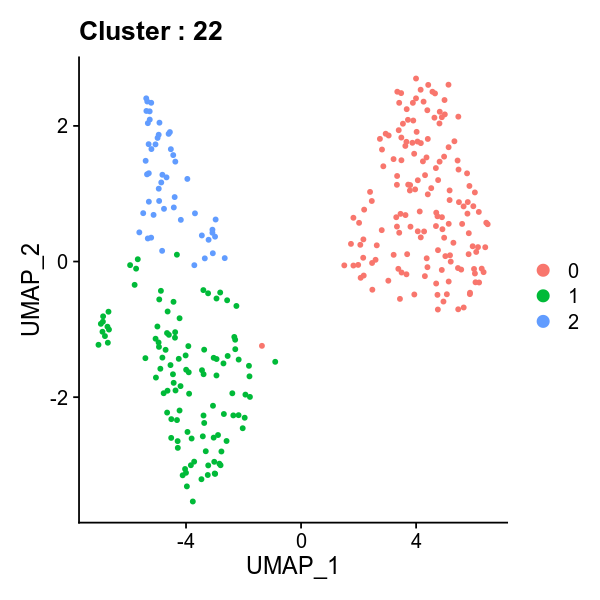

In [56]:
h_ = 5
w_ = 5
options(repr.plot.height=h_, repr.plot.width=w_)

res.c22$umap.graph

CD8s: clusters 0, 3, 6, 10

In [57]:
res.cd8<-list()
for (cl in c('0', '3', '6', '10')){
    print(paste0('Cluster: ', cl))
    res.cd8[[cl]]<-subcluster(so = abc.integrated, cluster_label = cl, resolution = 0.5)
    print('-------')
}

[1] "Cluster: 0"
[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 5556"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 12"
[1] "-------"
[1] "Cluster: 3"
[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 2476"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 5"
[1] "-------"
[1] "Cluster: 6"
[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 1645"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 4"
[1] "-------"
[1] "Cluster: 10"
[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 961"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 5"
[1] "-------"


$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

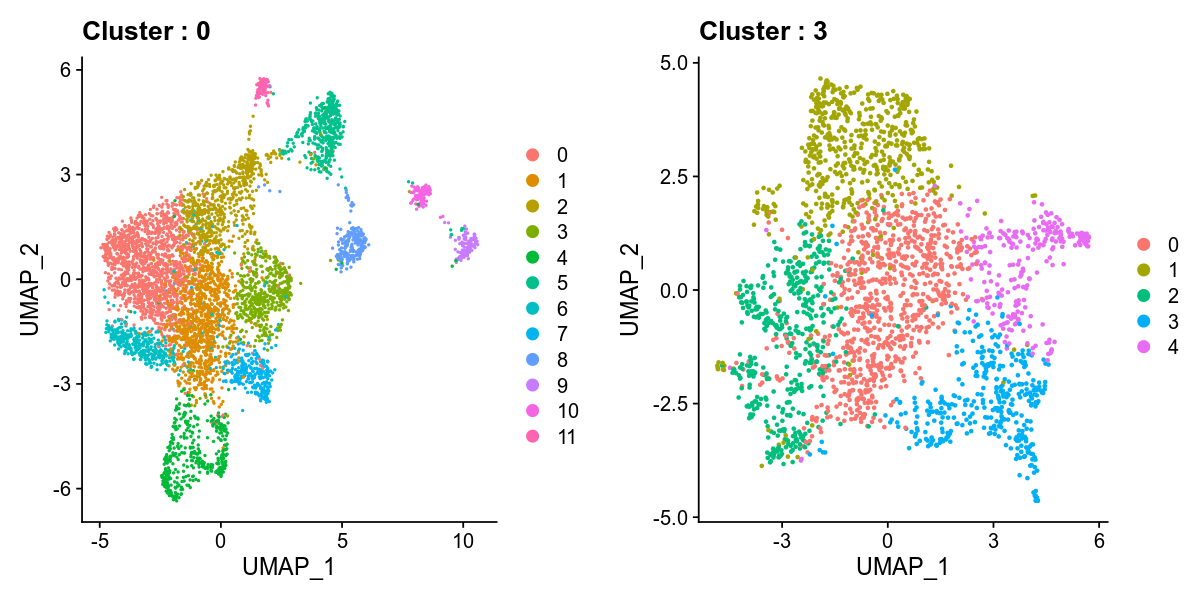

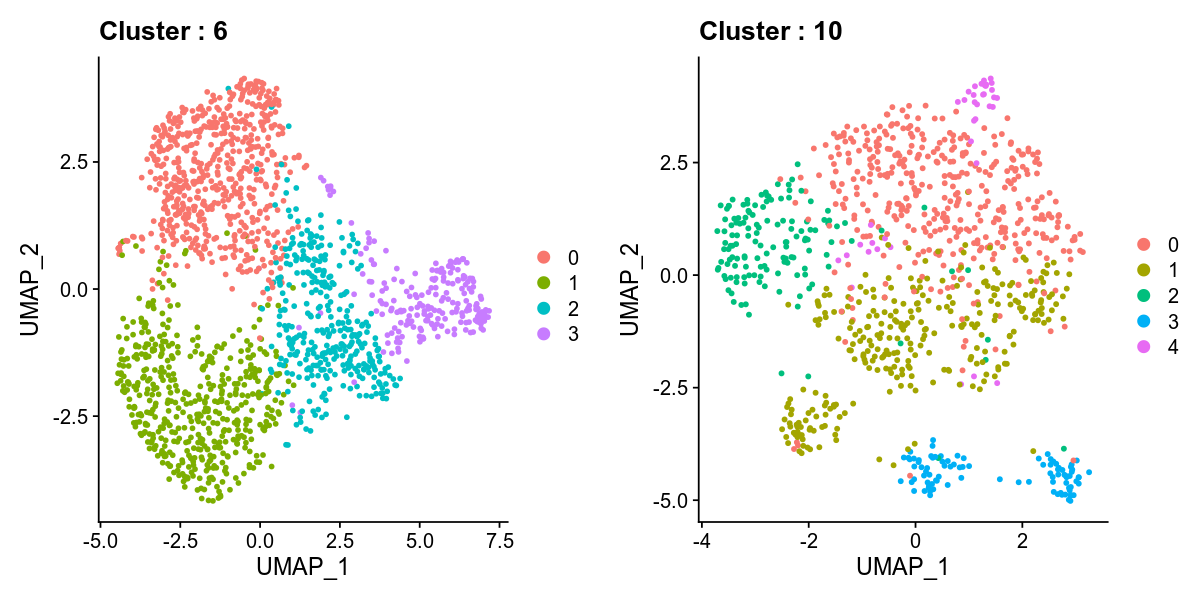

In [58]:
h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

ggarrange(res.cd8[[1]]$umap.graph, res.cd8[[2]]$umap.graph, 
          res.cd8[[3]]$umap.graph, res.cd8[[4]]$umap.graph, ncol = 2)

CD4s: 2, 15. Do not include cluster 21 because already re-annotated above

In [59]:
res.cd4<-list()
for (cl in c('2', '15')){
    print(paste0('Cluster: ', cl))
    res.cd4[[cl]]<-subcluster(so = abc.integrated, cluster_label = cl, resolution = 0.5)
    print('-------')
}

[1] "Cluster: 2"
[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 2579"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 8"
[1] "-------"
[1] "Cluster: 15"
[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 549"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 3"
[1] "-------"


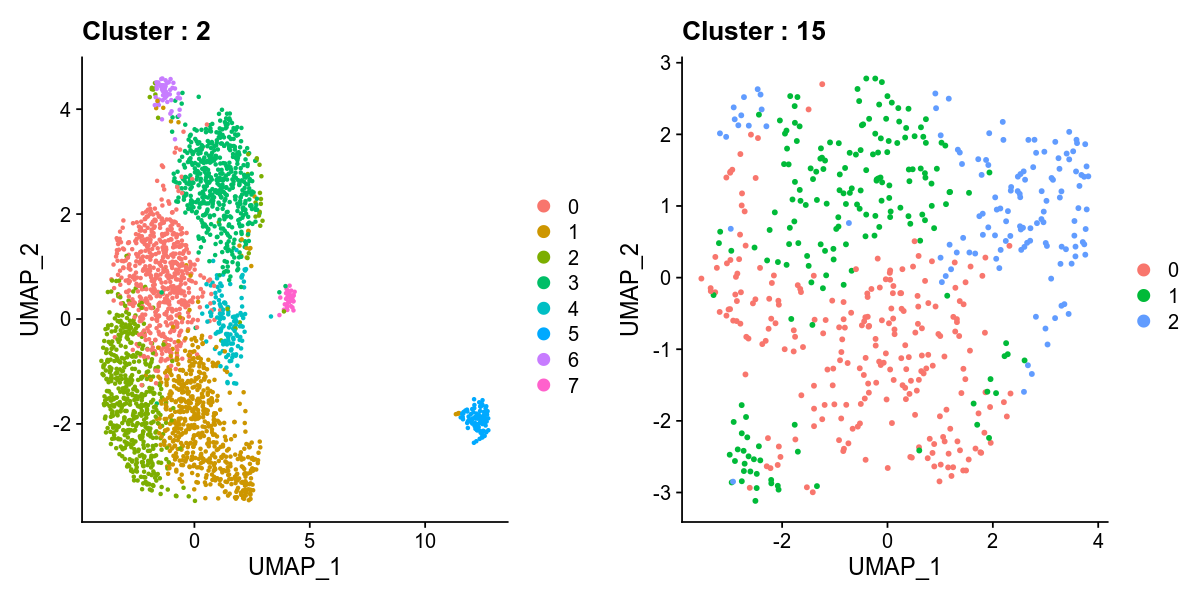

In [60]:
h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

ggarrange(res.cd4[[1]]$umap.graph, res.cd4[[2]]$umap.graph, ncol = 2)

## Markers

We repeat the marker wilcoxon method from before (02Ci), but this time, comparing each sub-cluster to all other cells in the dataset (excluding the ones dropped earlier in this notebook).

### Mapping

First, must map cluster labels of subsets. The largest cluster label currently is cluster 26. So for cluster 0 with 12 subclusters, this will become clusters 0, 27-37 (or also 0A-0L).

In [64]:
relabel.clusters<-function(so.subset, cluster.label.og, label.start){
    md<-so.subset@meta.data['seurat_clusters']
    n.clusters<-length(unique(md$seurat_clusters))
    cluster.labels<-sort(unique(as.numeric(md$seurat_clusters))) - 1

    cluster.labels.no<-c(cluster.label.og, 
                         seq(label.start+1, label.start+n.clusters - 1, by = 1))
    names(cluster.labels.no)<-as.character(cluster.labels)

    cluster.labels.let<-as.character(paste0(cluster.label.og, LETTERS[1:n.clusters]))
    md[['cluster.labels.no']]<-cluster.labels.no[md$seurat_clusters]
    md[['cluster.labels.let']]<-cluster.labels.let[md$seurat_clusters]
    
    so.subset@meta.data<-md
    
    return(list(so.subset = so.subset, max.cluster = max(cluster.labels.no)))
}

In [89]:
subclusters<-c(list('22' = res.c22), res.cd8, res.cd4)
subclusters<-subclusters[order(as.integer(names(subclusters)))]

label.start<-max(as.numeric(abc.integrated@meta.data$seurat_clusters)) - 1
for (i in seq_along(subclusters)){
    cluster.relabel<-relabel.clusters(so.subset = subclusters[[i]]$so.subset, 
                                    cluster.label.og = as.integer(names(subclusters)[[i]]), 
                                 label.start=label.start)
    subclusters[[i]][['so.subset']]<-cluster.relabel$so.subset
    label.start<-cluster.relabel$max.cluster
    
}

mapper.no<-c()
mapper.label<-c()
for (x in subclusters){
    mapper.no<-c(mapper.no, setNames(x$so.subset@meta.data$cluster.labels.no, rownames(x$so.subset@meta.data)))
    mapper.label<-c(mapper.label, setNames(x$so.subset@meta.data$cluster.labels.let, rownames(x$so.subset@meta.data)))
}

md<-abc.integrated@meta.data

md[['seurat_subcluster_no']]<-as.numeric(md$seurat_clusters) - 1
md[names(mapper.no), 'seurat_subcluster_no']<-unname(unlist(mapper.no))
md[['seurat_subcluster_no']]<-factor(x = md$seurat_subcluster_no,
                                     levels = sort(unique(md$seurat_subcluster_no)))

md[['seurat_subcluster_let']]<-as.character(md$seurat_clusters) 
md[names(mapper.label), 'seurat_subcluster_let']<-unname(unlist(mapper.label))
md[['seurat_subcluster_let']]<-factor(x = md$seurat_subcluster_let,
                                     levels = gtools::mixedsort(unique(md$seurat_subcluster_let)))

abc.integrated@meta.data<-md

Here is what that reannotation looks like:

In [104]:
cn<-c('Cell.Type.ScType', 'seurat_clusters', 'seurat_subcluster_no', 'seurat_subcluster_let')
head(md[md$seurat_clusters %in% names(subclusters), cn], n = 10)

,Cell.Type.ScType,seurat_clusters,seurat_subcluster_no,seurat_subcluster_let
,<fct>,<fct>,<fct>,<fct>
AAACCCAAGTATGAGT-1_1,Naive CD8+ T cells,0,30,0E
AAACCCACACTGCGAC-1_1,Naive CD8+ T cells,0,0,0A
AAACCCATCCACTTTA-1_1,Naive CD4+ T cells,2,40,2D
AAACGAATCATTACGG-1_1,Naive CD8+ T cells,0,35,0J
AAACGAATCCATTGGA-1_1,CD8+ NKT-like cells,10,53,10C
AAACGCTAGGCCTAGA-1_1,Naive CD4+ T cells,2,40,2D
AAACGCTTCACTGATG-1_1,Naive CD4+ T cells,2,43,2G
AAAGAACAGTATAACG-1_1,Naive CD8+ T cells,0,27,0B
AAAGAACCAGCAGATG-1_1,Naive CD4+ T cells,2,38,2B


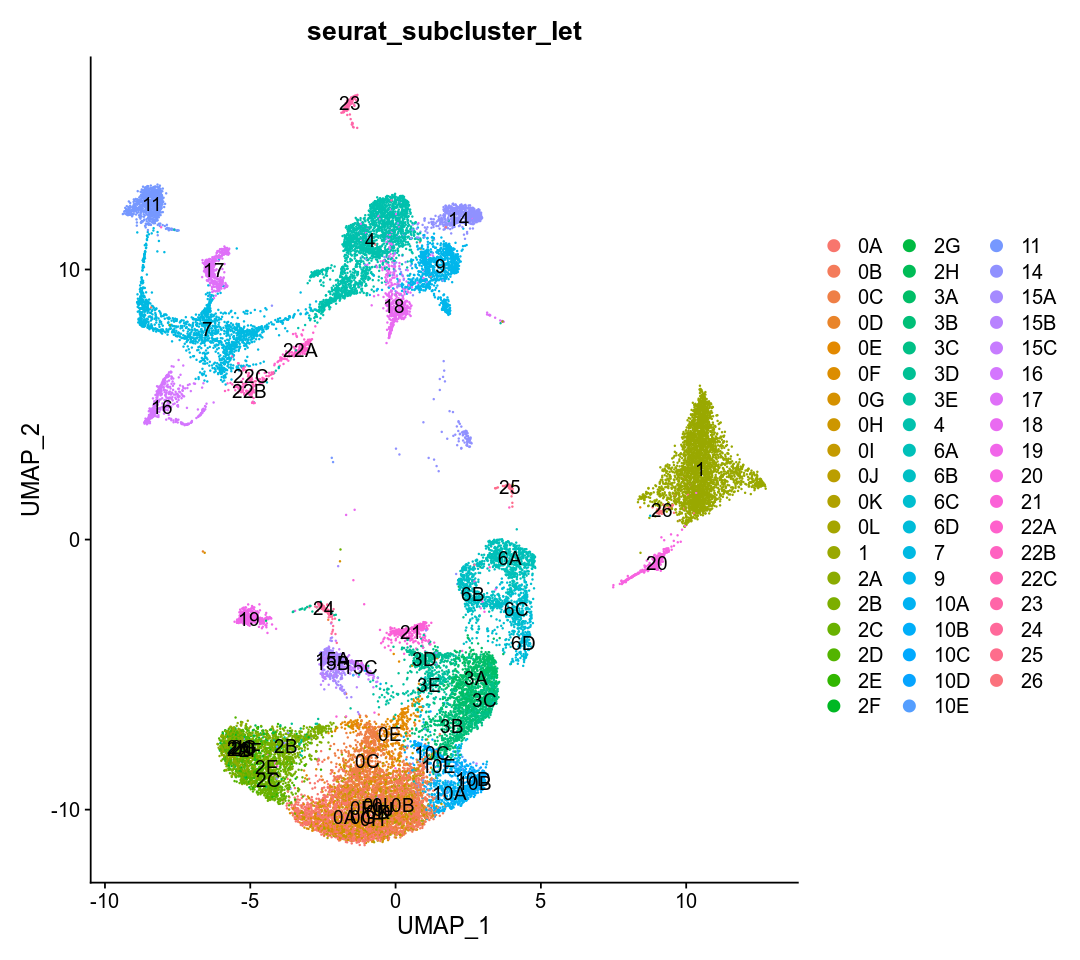

In [112]:
h_ = 8
w_ = 9
options(repr.plot.height=h_, repr.plot.width=w_)

DimPlot(abc.integrated, 
       group.by = 'seurat_subcluster_let', label = T)

### DE markers

In [186]:
Idents(abc.integrated)<-'seurat_subcluster_let'
subclusters<-sort(unique(md[md$seurat_clusters %in% names(subclusters), 'seurat_subcluster_let']))
subclusters

[1] 0A  0B  0C  0D  0E  0F  0G  0H  0I  0J  0K  0L  2A  2B  2C  2D  2E  2F  2G 
[20] 2H  3A  3B  3C  3D  3E  6A  6B  6C  6D  10A 10B 10C 10D 10E 15A 15B 15C 22A
[39] 22B 22C
56 Levels: 0A 0B 0C 0D 0E 0F 0G 0H 0I 0J 0K 0L 1 2A 2B 2C 2D 2E 2F 2G 2H ... 26

In [110]:
# markers.wilcoxon<-list()
# for (subcluster in subclusters){
#     print(subcluster)
#     de.res<-FindMarkers(object = abc.integrated, 
#                                     ident.1 = subcluster,
#                                     assay = 'RNA', only.pos = T, 
#                                        slot = 'data', test.use = 'wilcox', 
#                                        min.pct = 0.25, # stringent since markers
#                                         logfc.threshold = 0.5, 
#                                       )
#     de.res[['gene']]<-rownames(de.res)
#     de.res[['seurat_cluster_let']]<-subcluster
    
#     markers.wilcoxon[[subcluster]]<-de.res
# }
# saveRDS(markers.wilcoxon, paste0(data_path, 'interim/subcluster_markers.RDS'))
markers.wilcoxon<-readRDS(paste0(data_path, 'interim/subcluster_markers.RDS'))

In [191]:
mixedsort(unique(markers.wilcoxon$seurat_cluster_let))

NULL

In [205]:
# format markers
marker.excel<-function(marker, de.type = 'wilcoxon'){
    markers_workbook<-createWorkbook()
    for (cluster in mixedsort(unique(marker$seurat_cluster_let))){
        de.res.cl<-as.data.frame(marker[marker$seurat_cluster_let == cluster, ])
        rownames(de.res.cl)<-1:dim(de.res.cl)[[1]]

        addWorksheet(markers_workbook, cluster)
        writeData(markers_workbook, sheet = cluster, x = de.res.cl)
    }
    saveWorkbook(markers_workbook, overwrite = T, 
                 paste0(data_path, 'interim/', de.type, '_subcluster_markers.xlsx'))
}

padj.thresh<-0.1
lfc.thresh<-0.5
# additional formatting and filtering
marker<-do.call("rbind", markers.wilcoxon)
marker<-marker[marker$p_val_adj <= padj.thresh,] # threshold on p_adj
marker<-marker[marker$avg_log2FC > lfc.thresh,] # further threshold on LFC
marker<-marker[with(marker, order(seurat_cluster_let, -avg_log2FC)), ] # sort by effect size
md.subs<-md[md$seurat_subcluster_let %in% subclusters ,]
mapper<-setNames(md.subs$seurat_subcluster_no, md.subs$seurat_subcluster_let)
marker[['seurat_subcluster_no']]<-unlist(unname(mapper[marker$seurat_cluster_let]))
marker.excel(marker) # save to excel file

The number of DE genes per subcluster:

In [209]:
marker<-do.call("rbind", markers.wilcoxon)
marker<-marker[marker$p_val_adj <= padj.thresh,] # threshold on p_adj
marker<-marker[marker$avg_log2FC > lfc.thresh,] # further threshold on LFC"

table(marker$seurat_cluster_let)


  0A   0B   0C   0D   0E   0F   0G   0H   0I   0J   0K   0L  10A  10B  10C  10D 
  23   83   90   56  220   42   42   42   54   52   56   60  143  159  239  150 
 10E  15A  15B  15C  22A  22B  22C   2A   2B   2C   2D   2E   2F   2G   2H   3A 
  81   44   27  128 1234 3796 1381   76   52   19   62   37   65   70   39  426 
  3B   3C   3D   3E   6A   6B   6C   6D 
 337  576   96  119 2690 2087 2328 1419 

## ScType re-annotation

We also re-annotate the sub-clusters using ScType. While we probably won't use any of these annotations directly, they can perhaps guide the manual identification using the DE Markers.

In [120]:
source(paste0(sctype_path, 'sc-type/', 'R/gene_sets_prepare.R'))
source(paste0(sctype_path, 'sc-type/', 'R/sctype_score_.R'))       
db_<-paste0(sctype_path, 'sc-type/', 'ScTypeDB_full.xlsx')

path_to_db_file = db_
cell_type = "Immune system" 

cell_markers = openxlsx::read.xlsx(path_to_db_file)
cell_markers = cell_markers[cell_markers$tissueType == cell_type,] 
cell_markers$geneSymbolmore1 = gsub(" ","",cell_markers$geneSymbolmore1); cell_markers$geneSymbolmore2 = gsub(" ","",cell_markers$geneSymbolmore2)

tissue = "Immune system" 
# prepare gene sets
suppressWarnings({
    suppressMessages({
        gs_list = gene_sets_prepare(db_, tissue)
    })
})

In [121]:
md<-abc.integrated@meta.data

In [178]:
# get cell-type by cell matrix (scores each cell for each cell type)
es.max = sctype_score(scRNAseqData = abc.integrated@assays$integrated@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, gs2 = gs_list$gs_negative) 

# merge by cluster by taking the sum of the scores of each cell type
cL_resutls = do.call("rbind", lapply(unique(md$seurat_subcluster_let), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(md[md$seurat_subcluster_let==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(md$seurat_subcluster_let==cl)), 10)
}))

write.csv(cL_resutls, 
         paste0(data_path, 'interim/celltype_subcluster_scores.csv'))

# take max score of each cluster
sctype_scores = cL_resutls %>% group_by(cluster) %>% dplyr::top_n(n = 1, wt = scores)  
sctype_scores[['freq']]<-100*sctype_scores$ncells/sum(sctype_scores$ncells)

sctype_scores[['Confidence']]<-'good'
sctype_scores$Confidence[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "bad"

sctype_scores<-sctype_scores[with(sctype_scores, order(cluster)), ]


In [179]:
prev.annotated<-sctype_scores[!(sctype_scores$cluster %in% subclusters), ]

og.sctype.annotated<-read.csv(paste0(data_path, 'interim/celltype_cluster_scores.csv'))
og.sctype.annotated<-og.sctype.annotated[(colnames(og.sctype.annotated) != 'X')]
og.sctype.annotated = og.sctype.annotated %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  
og.sctype.annotated[['freq']]<-100*og.sctype.annotated$ncells/sum(og.sctype.annotated$ncells)
og.sctype.annotated[['Confidence']]<-'good'
og.sctype.annotated$Confidence[as.numeric(as.character(og.sctype.annotated$scores)) < og.sctype.annotated$ncells/4] = "bad"
og.sctype.annotated<-og.sctype.annotated[with(og.sctype.annotated, order(cluster)), ]
# og.sctype.annotated<-og.sctype.annotated[!(og.sctype.annotated$cluster %in% subclusters), ]
# og.sctype.annotated<-og.sctype.annotated[!(og.sctype.annotated$cluster %in% clusters.drop), ]
og.sctype.annotated<-og.sctype.annotated[og.sctype.annotated$cluster %in% as.character(prev.annotated$cluster), ]

if (identical(prev.annotated$type, og.sctype.annotated$type)){
    print('The re-run ScType annotations match the original ones for clusters that were not sub-clustered or dropped')
}

[1] "The re-run ScType annotations match the original ones for clusters that were not sub-clustered or dropped"


ScType annotates the sub-clusters as follows:

In [182]:
sctype_scores[(sctype_scores$cluster %in% subclusters),]

cluster,type,scores,ncells,freq,Confidence
<fct>,<chr>,<dbl>,<int>,<dbl>,<chr>
0A,Naive CD8+ T cells,2274.01845,1404,5.2139037,good
0B,Naive CD8+ T cells,1811.51706,1012,3.7581699,good
0C,ISG expressing immune cells,1669.89333,686,2.5475342,good
0D,Naive CD8+ T cells,807.49898,486,1.8048128,good
0E,Effector CD8+ T cells,541.38687,410,1.5225787,good
0F,Naive CD8+ T cells,585.63015,404,1.5002971,good
0G,Naive CD8+ T cells,651.15340,383,1.4223113,good
0H,Naive CD8+ T cells,468.66653,269,0.9989602,good
0I,Naive CD8+ T cells,305.01061,205,0.7612894,good


In [ ]:
write.csv(sctype_scores[(sctype_scores$cluster %in% subclusters),], 
                        paste0(data_path, 'interim/celltype_subclusteronly_scores.csv'))